# CFB Predictions

## Data Source:

collegefootballdata.com

### Query Parameters

WeekX-Games.csv: "Games and Results", Week = X, Division = fbs 

Player-PPA.csv: "Player Predicted Points Added by Season", Minimum of 1 snap (Threshold), Exclude Garbage Time

Player-Snaps.csv: "Player Usage metrics by season", Exclude Garbage Time

Team-Plays.csv: "Advanced Team Metrics by season", Exclude Garbage Time, Add Games manually

2023-Games.csv: "Games and Results", Division = fbs

SRS.csv: "Historical SRS Ratings", Year = 2023

Betting-Lines.csv: "Betting lines", Year = 2023

In [129]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [148]:
#Code Cell for function definitions
def elo_win_prob(home_elo, away_elo):
    elo_diff = home_elo - away_elo
    s = 400 #Scaling factor
    return 1/(1+10**(-elo_diff/s))

def expected_value_ml(home_elo_win_pct, home_ml, away_ml):
    home_decimal = np.where(home_ml < 0, 100/np.abs(home_ml), home_ml/100)
    away_decimal = np.where(away_ml < 0, 100/np.abs(away_ml), away_ml/100)
    home_ev = home_elo_win_pct * home_decimal - (1-home_elo_win_pct)
    away_ev = (1-home_elo_win_pct) * away_decimal - home_elo_win_pct
    return home_ev, away_ev

In [131]:
week5 = pd.read_csv("Week5-Games.csv")
week5 = week5.dropna().reset_index(drop=True) #Apparently I'm running an old pandas version
week5["Home Win Prob"] = elo_win_prob(week5["Home Pregame Elo"], week5["Away Pregame Elo"])
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,Away Conference,Away Division,Away Pregame Elo,Home Win Prob
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,American Athletic,fbs,1139.0,0.709355
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,Conference USA,fbs,1320.0,0.744730
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,Conference USA,fbs,1505.0,0.348088
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,ACC,fbs,1682.0,0.282408
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,Conference USA,fbs,1211.0,0.498561


### Historical Games Dataframe

This dataframe contains all of the games for 2023, both past and future. Primarily focused on past games for score analysis and back-testing

In [132]:
hist_games = pd.read_csv("2023-Games.csv")
hist_games = hist_games.dropna().reset_index(drop=True)
hist_games.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Points,Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo
0,2023,1,regular,True,Aviva Stadium,Notre Dame,FBS Independents,fbs,42.0,0.998958,1733,1819.0,Navy,American Athletic,fbs,3.0,0.001042,1471.0,1385.0
1,2023,1,regular,False,JSU Stadium,Jacksonville State,Conference USA,fbs,17.0,0.408001,1500,1499.0,UTEP,Conference USA,fbs,14.0,0.591999,1369.0,1370.0
2,2023,1,regular,False,Aggie Memorial Stadium,New Mexico State,Conference USA,fbs,30.0,0.239249,1322,1274.0,UMass,FBS Independents,fbs,41.0,0.760751,1074.0,1122.0
3,2023,1,regular,False,Snapdragon Stadium,San Diego State,Mountain West,fbs,20.0,0.954469,1488,1497.0,Ohio,Mid-American,fbs,13.0,0.045531,1482.0,1473.0
4,2023,1,regular,False,Vanderbilt Stadium,Vanderbilt,SEC,fbs,35.0,0.180846,1322,1327.0,Hawai'i,Mountain West,fbs,28.0,0.819154,1246.0,1241.0


### Player PPA Dataframe

This dataframe contains every player's Average Rush and Pass PPA (Predicted Points Added), as well as how many countable plays these figures are based on. 

In [133]:
player_ppa = pd.read_csv("Player-PPA.csv")
player_ppa.head()

,Season,Name,Position,Team,Conference,CountablePlays,AveragePPA Pass,AveragePPA Rush
0,2023,Joseph Bearns III,TE,Charlotte,American Athletic,1,-4.214,NaN
1,2023,Dante Lang,TE,Florida,SEC,1,-3.718,NaN
2,2023,Stephan Bracey,WR,Central Michigan,Mid-American,1,NaN,-2.523
3,2023,Cole Kramer,QB,Minnesota,Big Ten,2,-4.063,-0.157
4,2023,Cam'Ron McCoy,QB,Eastern Michigan,Mid-American,1,NaN,-1.618


### Player Snaps Dataframe

This dataframe contains every player's usage in games, where Pass Usage indicates what percentage of passing plays that player had a pass, incompletion, reception, or target, and Rush Usage indicates what percentage of rushing plays that player rushed.

In [134]:
player_snaps = pd.read_csv("Player-Snaps.csv")
player_snaps.head()

,Season,Name,Position,Team,Conference,Usage Overall,Usage Pass,Usage Rush
0,2023,Brayden Schager,QB,Hawai'i,Mountain West,0.7173,0.9862,0.1981
1,2023,Shedeur Sanders,QB,Colorado,Pac-12,0.7057,0.9842,0.1304
2,2023,Jacob Zeno,QB,UAB,American Athletic,0.6982,0.9942,0.2477
3,2023,Austin Reed,QB,Western Kentucky,Conference USA,0.6770,0.9518,0.1778
4,2023,Nick Vattiato,QB,Middle Tennessee,Conference USA,0.6754,0.9867,0.2845


### Team Plays Dataframe

This dataframe contains how many offensive plays each team has run, how many games they've played so far this season (manually added to the csv), how many of those plays were rushing or passing plays, and the defensive rushing and pass PPA.

In [135]:
team_plays = pd.read_csv("Team-Plays.csv")
team_plays["Tempo"] = team_plays["Offense Plays"]/team_plays["Games"] #Tempo: Avg. Offensive plays run per game
team_plays["Pass Snaps"] = team_plays["Tempo"]*team_plays["Offense PassingPlays Rate"]
team_plays["Rush Snaps"] = team_plays["Tempo"]*team_plays["Offense RushingPlays Rate"]
team_plays.head()

,Season,Team,Conference,Games,Offense Plays,Offense Drives,Offense Ppa,Offense RushingPlays Rate,Offense RushingPlays Ppa,Offense PassingPlays Rate,Offense PassingPlays Ppa,Defense RushingPlays Ppa,Defense PassingPlays Ppa,Tempo,Pass Snaps,Rush Snaps
0,2023,Boston College,ACC,4,245,42,0.226704,0.530612,0.267366,0.465306,0.187709,0.119299,0.631994,61.25,28.50,32.50
1,2023,Clemson,ACC,4,260,43,0.242673,0.469231,0.216689,0.530769,0.265644,0.043752,0.007715,65.00,34.50,30.50
2,2023,Duke,ACC,4,204,35,0.377522,0.500000,0.415066,0.500000,0.339979,0.073611,-0.058060,51.00,25.50,25.50
3,2023,Florida State,ACC,4,232,43,0.283487,0.469828,0.039358,0.530172,0.499828,0.039066,0.207319,58.00,30.75,27.25
4,2023,Georgia Tech,ACC,4,109,22,0.430178,0.495413,0.254235,0.495413,0.659458,0.143151,0.242273,27.25,13.50,13.50


### SRS Dataframe

This dataframe contains each team's SRS (Simple Rating System), which is essentially a measure of how far above or below average each team is. A team's margin of victory can theoretically be estimated by subtracting their opponent's SRS from their own SRS

In [136]:
SRS = pd.read_csv("SRS.csv")
SRS.head()

,Year,Team,Conference,Division,Rating,Ranking
0,2023,Penn State,Big Ten,East,29.5,1
1,2023,Oregon,Pac-12,NaN,28.8,2
2,2023,Washington,Pac-12,NaN,28.4,3
3,2023,Texas,Big 12,NaN,24.7,4
4,2023,Miami,ACC,Coastal,22.4,5


### Betting Lines

This dataframe contains historical and current betting lines for college football games

In [152]:
betting_lines = pd.read_csv("Betting-Lines.csv")
betting_lines = betting_lines[betting_lines["LineProvider"] == "DraftKings"]
betting_lines.head()

,Id,HomeTeam,AwayTeam,LineProvider,OverUnder,Spread,HomeMoneyline,AwayMoneyline
29,401520276,Sam Houston State,Jacksonville State,DraftKings,36.5,6.5,205.0,-250.0
47,401520152,BYU,Sam Houston State,DraftKings,46.5,-20.0,-1200.0,850.0
52,401520193,Indiana,Indiana State,DraftKings,45.5,-31.0,NaN,NaN
54,401520185,Army,Delaware State,DraftKings,44.0,-39.5,NaN,NaN
56,401520208,Ohio State,Youngstown State,DraftKings,56.5,-45.0,NaN,NaN


## Data Manipulation

In [137]:
passes = [] #List so pandas doesn't yell at us
rushes = []
for i in range(player_snaps.shape[0]):
    pass_snaps = float(team_plays[team_plays["Team"] == player_snaps["Team"].loc[i]]["Pass Snaps"]) #Lookup team rush/pass snaps
    rush_snaps = float(team_plays[team_plays["Team"] == player_snaps["Team"].loc[i]]["Rush Snaps"]) #Float conversions cause pandas
    passes.append(pass_snaps * float(player_snaps["Usage Pass"].loc[i])) #Calculate average player rush/pass snaps per game
    rushes.append(pass_snaps * float(player_snaps["Usage Rush"].loc[i]))
    
player_snaps["Pass Snaps"] = passes
player_snaps["Rush Snaps"] = rushes
player_snaps.head()

,Season,Name,Position,Team,Conference,Usage Overall,Usage Pass,Usage Rush,Pass Snaps,Rush Snaps
0,2023,Brayden Schager,QB,Hawai'i,Mountain West,0.7173,0.9862,0.1981,38.067320,7.646660
1,2023,Shedeur Sanders,QB,Colorado,Pac-12,0.7057,0.9842,0.1304,41.090350,5.444200
2,2023,Jacob Zeno,QB,UAB,American Athletic,0.6982,0.9942,0.2477,36.288300,9.041050
3,2023,Austin Reed,QB,Western Kentucky,Conference USA,0.6770,0.9518,0.1778,35.930450,6.711950
4,2023,Nick Vattiato,QB,Middle Tennessee,Conference USA,0.6754,0.9867,0.2845,34.287825,9.886375


In [138]:
temp_snaps = player_snaps.drop(columns=["Season","Position","Team","Conference","Usage Overall","Usage Pass", "Usage Rush"])
player_ppa = player_ppa.merge(temp_snaps, on="Name")
player_ppa = player_ppa.fillna(0) #Replace NaN with 0
player_ppa.head()

,Season,Name,Position,Team,Conference,CountablePlays,AveragePPA Pass,AveragePPA Rush,Pass Snaps,Rush Snaps
0,2023,Joseph Bearns III,TE,Charlotte,American Athletic,1,-4.214,0.000,0.23735,0.000000
1,2023,Dante Lang,TE,Florida,SEC,1,-3.718,0.000,0.23240,0.000000
2,2023,Stephan Bracey,WR,Central Michigan,Mid-American,1,0.000,-2.523,0.00000,0.152425
3,2023,Cole Kramer,QB,Minnesota,Big Ten,2,-4.063,-0.157,0.24920,0.193200
4,2023,Cam'Ron McCoy,QB,Eastern Michigan,Mid-American,1,0.000,-1.618,0.00000,0.280500


In [139]:
home_off = []
away_off = []
for i in range(week5.shape[0]):
    home = week5["Home Team"].loc[i]
    away = week5["Away Team"].loc[i]
    home_players = player_ppa[player_ppa["Team"] == home]
    away_players = player_ppa[player_ppa["Team"] == away]
    home_pts = home_players["Pass Snaps"]*home_players["AveragePPA Pass"] + home_players["Rush Snaps"]*home_players["AveragePPA Rush"]
    away_pts = away_players["Pass Snaps"]*away_players["AveragePPA Pass"] + away_players["Rush Snaps"]*away_players["AveragePPA Rush"]
    home_off.append(home_pts.sum())
    away_off.append(away_pts.sum())
    
    
week5["Raw Offense (Home)"] = home_off
week5["Raw Offense (Away)"] = away_off
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,Away Conference,Away Division,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away)
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,American Athletic,fbs,1139.0,0.709355,21.288642,34.994974
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,Conference USA,fbs,1320.0,0.744730,32.554932,33.716632
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,Conference USA,fbs,1505.0,0.348088,-3.716954,13.563470
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,ACC,fbs,1682.0,0.282408,23.891467,32.006050
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,Conference USA,fbs,1211.0,0.498561,23.169687,27.676378


In [140]:
home_pts = []
away_pts = []
for i in range(week5.shape[0]):
    home = team_plays[team_plays["Team"] == week5["Home Team"].loc[i]] #Combine this cell and the one above for neatness
    away = team_plays[team_plays["Team"] == week5["Away Team"].loc[i]]
    #Functionize the below lines, so they're not so godawful
    home_def = float(home["Defense PassingPlays Ppa"])*float(away["Pass Snaps"]) + float(home["Defense RushingPlays Ppa"])*float(away["Rush Snaps"])
    away_def = float(away["Defense PassingPlays Ppa"])*float(home["Pass Snaps"]) + float(away["Defense RushingPlays Ppa"])*float(home["Rush Snaps"])
    home_pts.append(week5["Raw Offense (Home)"].loc[i] + away_def)
    away_pts.append(week5["Raw Offense (Away)"].loc[i] + home_def)
    
week5["Home Pts"] = home_pts
week5["Away Pts"] = away_pts
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,Away Conference,Away Division,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away),Home Pts,Away Pts
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,American Athletic,fbs,1139.0,0.709355,21.288642,34.994974,34,58
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,Conference USA,fbs,1320.0,0.744730,32.554932,33.716632,49,53
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,Conference USA,fbs,1505.0,0.348088,-3.716954,13.563470,-1,22
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,ACC,fbs,1682.0,0.282408,23.891467,32.006050,31,37
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,Conference USA,fbs,1211.0,0.498561,23.169687,27.676378,33,45


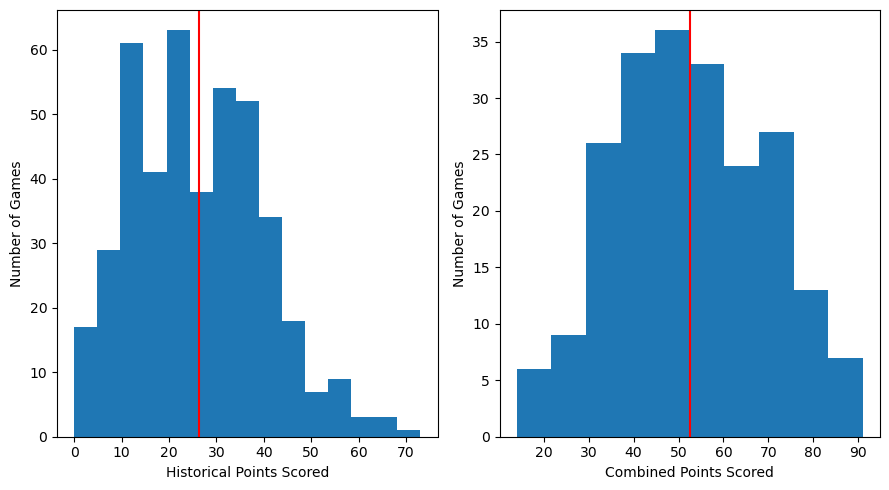

In [141]:
hist_games["Total"] = hist_games["Home Points"] + hist_games["Away Points"]
results = np.concatenate((hist_games["Home Points"].to_numpy(),hist_games["Away Points"].to_numpy()),axis=None)
avg_total = np.mean(results)
total_std = np.std(results)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.hist(results,bins=15)
plt.axvline(avg_total,c="r")
plt.xlabel("Historical Points Scored")
plt.ylabel("Number of Games")
plt.subplot(1,2,2)
plt.hist(hist_games["Total"])
plt.axvline(np.mean(hist_games["Total"]),c="r")
plt.xlabel("Combined Points Scored")
plt.ylabel("Number of Games")
plt.tight_layout()

Data Scaling Idea found here: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation

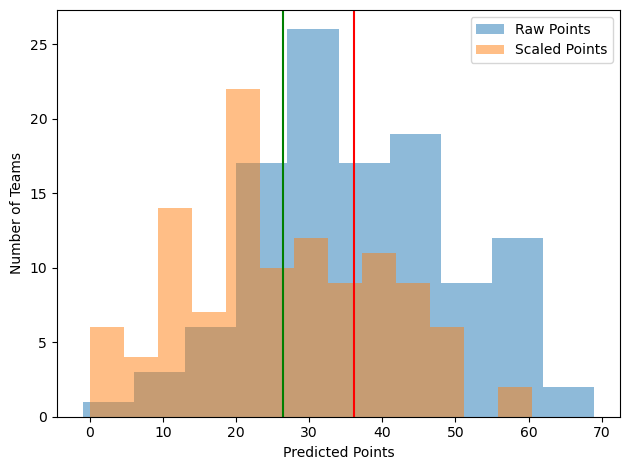

In [142]:
week5["Total"] = week5["Home Pts"] + week5["Away Pts"]
preds = np.concatenate((week5["Home Pts"].to_numpy(),week5["Away Pts"].to_numpy()),axis=None)
pred_avg = np.mean(preds)
pred_std = np.std(preds)
plt.hist(preds,alpha=0.5,label="Raw Points")
plt.axvline(pred_avg,c="r")
plt.xlabel("Predicted Points")
plt.ylabel("Number of Teams")
scaled_preds = avg_total + (preds-pred_avg)*(total_std/pred_std)
scaled_preds[scaled_preds < 0] = 0
plt.hist(scaled_preds,bins=13,alpha=0.5,label="Scaled Points")
plt.axvline(np.mean(scaled_preds),c="g")
plt.legend()
plt.tight_layout()

In [146]:
home, away = np.split(scaled_preds,2)
week5["Home Pts"] = home.astype(int)
week5["Away Pts"] = away.astype(int)
week5["Total"] = week5["Home Pts"] + week5["Away Pts"]
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,...,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away),Home Pts,Away Pts,Total,Home SRS,Away SRS,SRS Spread
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,...,1139.0,0.709355,21.288642,34.994974,24,48,72,-4.7,-8.9,-4.2
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,...,1320.0,0.744730,32.554932,33.716632,39,43,82,0.4,-3.8,-4.2
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,...,1505.0,0.348088,-3.716954,13.563470,0,11,11,-13.2,-9.1,4.1
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,...,1682.0,0.282408,23.891467,32.006050,20,27,47,-5.2,12.2,17.4
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,...,1211.0,0.498561,23.169687,27.676378,22,35,57,-17.6,-17.3,0.3


In [144]:
home_srs = []
away_srs = []
for i in range(week5.shape[0]):
    home = SRS[SRS["Team"] == week5["Home Team"].loc[i]] #Combine this cell and the one above for neatness
    away = SRS[SRS["Team"] == week5["Away Team"].loc[i]]
    #Functionize the below lines, so they're not so godawful
    home_srs.append(float(home["Rating"]))
    away_srs.append(float(away["Rating"]))
    
week5["Home SRS"] = home_srs
week5["Away SRS"] = away_srs
week5["SRS Spread"] = week5["Away SRS"] - week5["Home SRS"]
week5.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Pregame Elo,Away Team,...,Away Pregame Elo,Home Win Prob,Raw Offense (Home),Raw Offense (Away),Home Pts,Away Pts,Total,Home SRS,Away SRS,SRS Spread
0,2023,5,regular,False,Skelly Field at H. A. Chapman Stadium,Tulsa,American Athletic,fbs,1294,Temple,...,1139.0,0.709355,21.288642,34.994974,24.014467,48.987453,73.001920,-4.7,-8.9,-4.2
1,2023,5,regular,False,Houchens Industries-L. T. Smith Stadium,Western Kentucky,Conference USA,fbs,1506,Middle Tennessee,...,1320.0,0.744730,32.554932,33.716632,39.622583,43.784748,83.407331,0.4,-3.8,-4.2
2,2023,5,regular,False,Bowers Stadium,Sam Houston State,Conference USA,fbs,1396,Jacksonville State,...,1505.0,0.348088,-3.716954,13.563470,0.000000,11.527974,11.527974,-13.2,-9.1,4.1
3,2023,5,regular,False,Carter-Finley Stadium,NC State,ACC,fbs,1520,Louisville,...,1682.0,0.282408,23.891467,32.006050,20.892844,27.136090,48.028934,-5.2,12.2,17.4
4,2023,5,regular,False,Sun Bowl Stadium,UTEP,Conference USA,fbs,1210,Louisiana Tech,...,1211.0,0.498561,23.169687,27.676378,22.973926,35.460419,58.434345,-17.6,-17.3,0.3


## Initial Observations

Exploratory Analysis done in an excel workbook for ease of manipulation and visualization
* Initial predictions are decent at predicting winners (~70% prediction accuracy)
* Point differential pedictions are okay (16.7% within 3 points, 33.3% within 7 points)
* Predicting exact points tends to overshoot actual points, introduce scaling factor to reduce predicted score (Unsure whether to apply to raw offense or final predicted points)
* Manually scaling performs poorly, maybe use machine learning to determine optimal scaling
* Adjusting player snap threshold doesn't have a significant effect on outcomes, which makes sense as players with very few snaps have a very small impact on the game

## Back-Testing

In [149]:
hist_games["Elo Win Pct"] = elo_win_prob(hist_games["Home Pregame Elo"], hist_games["Away Pregame Elo"])
hist_games.head()

,Season,Week,Season Type,Neutral Site,Venue,Home Team,Home Conference,Home Division,Home Points,Home Post Win Prob,...,Home Postgame Elo,Away Team,Away Conference,Away Division,Away Points,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Total,Elo Win Pct
0,2023,1,regular,True,Aviva Stadium,Notre Dame,FBS Independents,fbs,42.0,0.998958,...,1819.0,Navy,American Athletic,fbs,3.0,0.001042,1471.0,1385.0,45.0,0.818793
1,2023,1,regular,False,JSU Stadium,Jacksonville State,Conference USA,fbs,17.0,0.408001,...,1499.0,UTEP,Conference USA,fbs,14.0,0.591999,1369.0,1370.0,31.0,0.680071
2,2023,1,regular,False,Aggie Memorial Stadium,New Mexico State,Conference USA,fbs,30.0,0.239249,...,1274.0,UMass,FBS Independents,fbs,41.0,0.760751,1074.0,1122.0,71.0,0.806528
3,2023,1,regular,False,Snapdragon Stadium,San Diego State,Mountain West,fbs,20.0,0.954469,...,1497.0,Ohio,Mid-American,fbs,13.0,0.045531,1482.0,1473.0,33.0,0.508634
4,2023,1,regular,False,Vanderbilt Stadium,Vanderbilt,SEC,fbs,35.0,0.180846,...,1327.0,Hawai'i,Mountain West,fbs,28.0,0.819154,1246.0,1241.0,63.0,0.607661


In [151]:
hist_games["Elo Accuracy"] = np.where(((hist_games["Elo Win Pct"]>0.5)&(hist_games["Home Points"]>hist_games["Away Points"])) |
         ((hist_games["Elo Win Pct"]<0.5)&(hist_games["Home Points"]<hist_games["Away Points"])), 1, 0)
print(np.mean(hist_games["Elo Accuracy"]))

0.7627906976744186
